In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np

# Set a fixed random seed for reproducibility
random.seed(123)
random_state = 123

# -----------------------------
# Part 1: Load and Prepare Data
# -----------------------------

# Read the first CSV file
df_train_data = pd.read_csv('adult.data.csv', header=None)

# Read the second CSV file, skipping the first row
df_test_data_original = pd.read_csv('adult.test.csv', skiprows=1, header=None)

# Clean the income column in df_test_data_original (remove periods and extra whitespace)
df_test_data_original.iloc[:, -1] = df_test_data_original.iloc[:, -1].str.replace('.', '', regex=False).str.strip()

# Concatenate the two DataFrames to create a combined dataset
df_total = pd.concat([df_train_data, df_test_data_original], ignore_index=True)

# Define column names
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]
df_total.columns = column_names

# Replace '?' with NaN
df_total.replace('?', np.nan, inplace=True)

# Handle missing values by replacing with 'Unknown'
for col in ['workclass', 'occupation', 'native-country']:
    df_total[col].fillna('Unknown', inplace=True)

# Clean the 'income' column (remove periods and extra whitespace)
df_total['income'] = df_total['income'].str.replace('.', '', regex=False).str.strip()

# Convert 'income' to binary values
df_total['income'] = df_total['income'].map({'<=50K': 0, '>50K': 1})

# Verify that there are no NaN values in 'income'
assert not df_total['income'].isnull().any(), "Error: 'income' column contains NaN values after mapping."

# Identify categorical columns
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_total, columns=categorical_columns)


In [2]:
# -----------------------------
# Part 2: Split the Data
# -----------------------------

# Separate features and target variable
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

# First split: 90% temp (train+validation), 10% test
X_temp, X_test_split, y_temp, y_test_split = train_test_split(
    X, y, test_size=0.10, random_state=random_state, stratify=y
)

# Second split: 70% train, 20% validation from temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2222, random_state=random_state, stratify=y_temp
)

# Reset indices
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test_split.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test_split.reset_index(drop=True, inplace=True)

In [3]:
# -----------------------------
# Part 3: Save the Data
# -----------------------------

# Combine features and target
df_train = pd.concat([X_train, y_train], axis=1)
df_validation = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test_split, y_test_split], axis=1)

# Save to CSV files
df_train.to_csv('adult.newData.csv', index=False)
df_validation.to_csv('adult.newValidation.csv', index=False)
df_test.to_csv('adult.newTest.csv', index=False)

In [4]:
total_size = len(df_total)
train_size = len(df_train)
val_size = len(df_validation)
test_size = len(df_test)

print(f"Total Size: {total_size}")
print(f"Train Size: {train_size} ({train_size/total_size*100:.2f}%)")
print(f"Validation Size: {val_size} ({val_size/total_size*100:.2f}%)")
print(f"Test Size: {test_size} ({test_size/total_size*100:.2f}%)")


Total Size: 48842
Train Size: 34189 (70.00%)
Validation Size: 9768 (20.00%)
Test Size: 4885 (10.00%)


k=1, Validation Accuracy: 0.7943
k=3, Validation Accuracy: 0.8164
k=5, Validation Accuracy: 0.8261
k=7, Validation Accuracy: 0.8339
k=9, Validation Accuracy: 0.8352
k=11, Validation Accuracy: 0.8380
k=13, Validation Accuracy: 0.8389
k=15, Validation Accuracy: 0.8389
k=17, Validation Accuracy: 0.8379
k=19, Validation Accuracy: 0.8386
k=21, Validation Accuracy: 0.8390


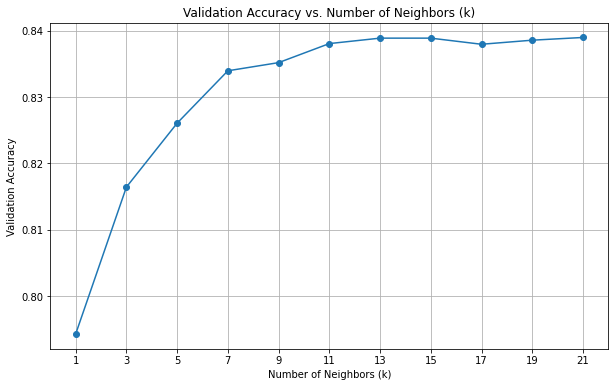


Optimal k value: 21

Classification Report for k-NN Classifier with Optimal k on Validation Set:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7431
           1       0.69      0.58      0.63      2337

    accuracy                           0.84      9768
   macro avg       0.78      0.75      0.77      9768
weighted avg       0.83      0.84      0.83      9768

Confusion Matrix:
[[6830  601]
 [ 972 1365]]


In [22]:
# -----------------------------
# Part 4.1: k-Nearest Neighbors (k-NN) Classifier
# -----------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Feature Scaling
# Identify numerical columns
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Transform the validation and test data
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test_split[numerical_columns] = scaler.transform(X_test_split[numerical_columns])

# Assess performance for different values of k
k_values = range(1, 22,2)
accuracy_scores = []

for k in k_values:
    # Initialize the k-NN classifier with the current k
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the classifier on the training data
    knn.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = knn.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)
    
    print(f'k={k}, Validation Accuracy: {accuracy:.4f}')

# Plot the accuracy scores vs. k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Select the optimal k (the one with the highest accuracy)
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]
print(f'\nOptimal k value: {optimal_k}')

# Retrain the k-NN classifier with the optimal k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)

# Predict on the validation set with the optimal k
y_val_pred_optimal = knn_optimal.predict(X_val)

# Evaluate the performance
print('\nClassification Report for k-NN Classifier with Optimal k on Validation Set:')
print(classification_report(y_val, y_val_pred_optimal))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_optimal)
print('Confusion Matrix:')
print(cm)




k=1, Validation Accuracy (Manhattan): 0.7928
k=2, Validation Accuracy (Manhattan): 0.8118
k=3, Validation Accuracy (Manhattan): 0.8181
k=4, Validation Accuracy (Manhattan): 0.8207
k=5, Validation Accuracy (Manhattan): 0.8257
k=6, Validation Accuracy (Manhattan): 0.8324
k=7, Validation Accuracy (Manhattan): 0.8344
k=8, Validation Accuracy (Manhattan): 0.8325
k=9, Validation Accuracy (Manhattan): 0.8327
k=10, Validation Accuracy (Manhattan): 0.8348
k=11, Validation Accuracy (Manhattan): 0.8333
k=12, Validation Accuracy (Manhattan): 0.8351
k=13, Validation Accuracy (Manhattan): 0.8362
k=14, Validation Accuracy (Manhattan): 0.8347
k=15, Validation Accuracy (Manhattan): 0.8364
k=16, Validation Accuracy (Manhattan): 0.8373
k=17, Validation Accuracy (Manhattan): 0.8381
k=18, Validation Accuracy (Manhattan): 0.8375
k=19, Validation Accuracy (Manhattan): 0.8377
k=20, Validation Accuracy (Manhattan): 0.8380


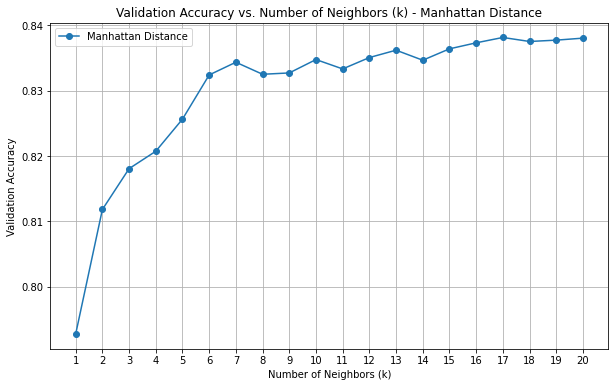


Optimal k value (Manhattan): 17

Classification Report for k-NN Classifier with Optimal k (Manhattan) on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      7431
           1       0.70      0.57      0.63      2337

    accuracy                           0.84      9768
   macro avg       0.79      0.75      0.76      9768
weighted avg       0.83      0.84      0.83      9768

Confusion Matrix (Manhattan):
[[6856  575]
 [1006 1331]]


In [6]:
# -----------------------------
# Part 4.2: k-Nearest Neighbors (k-NN) Classifier with Manhattan Distance
# -----------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Feature Scaling
# Identify numerical columns
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Transform the validation and test data
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test_split[numerical_columns] = scaler.transform(X_test_split[numerical_columns])

# Assess performance for different values of k using Manhattan distance
k_values = range(1, 21)
accuracy_scores_manhattan = []

for k in k_values:
    # Initialize the k-NN classifier with Manhattan distance
    knn_manhattan = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    
    # Train the classifier on the training data
    knn_manhattan.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred_manhattan = knn_manhattan.predict(X_val)
    
    # Calculate accuracy
    accuracy_manhattan = accuracy_score(y_val, y_val_pred_manhattan)
    accuracy_scores_manhattan.append(accuracy_manhattan)
    
    print(f'k={k}, Validation Accuracy (Manhattan): {accuracy_manhattan:.4f}')

# Plot the accuracy scores vs. k values for Manhattan distance
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores_manhattan, marker='o', label='Manhattan Distance')
plt.title('Validation Accuracy vs. Number of Neighbors (k) - Manhattan Distance')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Select the optimal k for Manhattan distance
optimal_k_manhattan = k_values[accuracy_scores_manhattan.index(max(accuracy_scores_manhattan))]
print(f'\nOptimal k value (Manhattan): {optimal_k_manhattan}')

# Retrain the k-NN classifier with the optimal k using Manhattan distance
knn_optimal_manhattan = KNeighborsClassifier(n_neighbors=optimal_k_manhattan, metric='manhattan')
knn_optimal_manhattan.fit(X_train, y_train)

# Predict on the validation set with the optimal k
y_val_pred_optimal_manhattan = knn_optimal_manhattan.predict(X_val)

# Evaluate the performance
print('\nClassification Report for k-NN Classifier with Optimal k (Manhattan) on Validation Set:')
print(classification_report(y_val, y_val_pred_optimal_manhattan))

# Confusion Matrix
cm_manhattan = confusion_matrix(y_val, y_val_pred_optimal_manhattan)
print('Confusion Matrix (Manhattan):')
print(cm_manhattan)


Original training set class distribution: Counter({0: 26008, 1: 8181})
Resampled training set class distribution: Counter({1: 26008, 0: 26008})
k=1, Validation Accuracy (with SMOTE): 0.7821
k=3, Validation Accuracy (with SMOTE): 0.7860
k=5, Validation Accuracy (with SMOTE): 0.7849
k=7, Validation Accuracy (with SMOTE): 0.7846
k=9, Validation Accuracy (with SMOTE): 0.7824
k=11, Validation Accuracy (with SMOTE): 0.7816
k=13, Validation Accuracy (with SMOTE): 0.7813
k=15, Validation Accuracy (with SMOTE): 0.7778
k=17, Validation Accuracy (with SMOTE): 0.7763
k=19, Validation Accuracy (with SMOTE): 0.7758
k=21, Validation Accuracy (with SMOTE): 0.7746
k=23, Validation Accuracy (with SMOTE): 0.7727


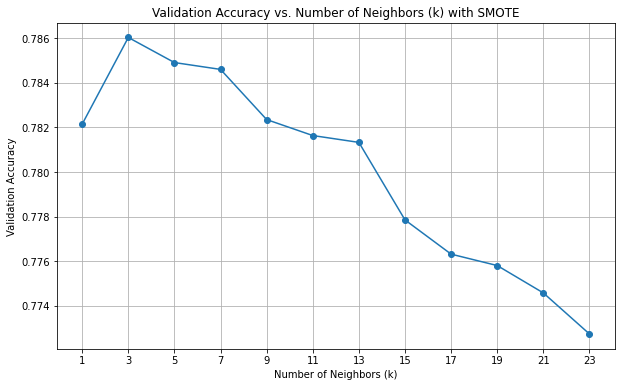


Optimal k value after SMOTE: 3

Classification Report for k-NN Classifier with Optimal k (SMOTE) on Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      7431
           1       0.54      0.73      0.62      2337

    accuracy                           0.79      9768
   macro avg       0.72      0.77      0.74      9768
weighted avg       0.82      0.79      0.80      9768

Confusion Matrix:
[[5974 1457]
 [ 633 1704]]


In [18]:
# -----------------------------
# Part 4.3: k-Nearest Neighbors (k-NN) Classifier with SMOTE
# -----------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter

# Feature Scaling
# Identify numerical columns
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Transform the validation and test data
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test_split[numerical_columns] = scaler.transform(X_test_split[numerical_columns])

# -----------------------------
# Apply SMOTE to Address Class Imbalance
# -----------------------------

# Initialize SMOTE
smote = SMOTE(random_state=random_state)

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print('Original training set class distribution:', Counter(y_train))
print('Resampled training set class distribution:', Counter(y_train_resampled))

# -----------------------------
# Assess performance for different values of k using Resampled Data
# -----------------------------

k_values = range(1, 24,2)
accuracy_scores = []

for k in k_values:
    # Initialize the k-NN classifier with the current k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train the classifier on the resampled training data
    knn.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the validation set
    y_val_pred = knn.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)
    
    print(f'k={k}, Validation Accuracy (with SMOTE): {accuracy:.4f}')

# Plot the accuracy scores vs. k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Validation Accuracy vs. Number of Neighbors (k) with SMOTE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Select the optimal k (the one with the highest accuracy)
optimal_k_smote = k_values[accuracy_scores.index(max(accuracy_scores))]
print(f'\nOptimal k value after SMOTE: {optimal_k_smote}')

# Retrain the k-NN classifier with the optimal k using resampled data
knn_optimal_smote = KNeighborsClassifier(n_neighbors=optimal_k_smote)
knn_optimal_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set with the optimal k
y_val_pred_optimal_smote = knn_optimal_smote.predict(X_val)

# Evaluate the performance
print('\nClassification Report for k-NN Classifier with Optimal k (SMOTE) on Validation Set:')
print(classification_report(y_val, y_val_pred_optimal_smote))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_optimal_smote)
print('Confusion Matrix:')
print(cm)


In [8]:
# -----------------------------
# Part 5: Naïve Bayes Classifier (GaussianNB) from the scikit-learn library
# -----------------------------

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Gaussian Naïve Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = gnb.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f'\nValidation Accuracy (GaussianNB): {accuracy:.4f}')

# Evaluate the performance
print('\nClassification Report for Gaussian Naïve Bayes Classifier on Validation Set:')
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(cm)



Validation Accuracy (GaussianNB): 0.5945

Classification Report for Gaussian Naïve Bayes Classifier on Validation Set:
              precision    recall  f1-score   support

           0       0.95      0.49      0.65      7431
           1       0.36      0.93      0.52      2337

    accuracy                           0.59      9768
   macro avg       0.66      0.71      0.58      9768
weighted avg       0.81      0.59      0.62      9768

Confusion Matrix:
[[3645 3786]
 [ 175 2162]]



Validation Accuracy (Decision Tree): 0.8098

Classification Report for Decision Tree Classifier on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7431
           1       0.60      0.60      0.60      2337

    accuracy                           0.81      9768
   macro avg       0.74      0.74      0.74      9768
weighted avg       0.81      0.81      0.81      9768

Confusion Matrix:
[[6506  925]
 [ 933 1404]]
max_depth=1, Validation Accuracy: 0.7607
max_depth=2, Validation Accuracy: 0.8257
max_depth=3, Validation Accuracy: 0.8392
max_depth=4, Validation Accuracy: 0.8391
max_depth=5, Validation Accuracy: 0.8433
max_depth=6, Validation Accuracy: 0.8488
max_depth=7, Validation Accuracy: 0.8491
max_depth=8, Validation Accuracy: 0.8480
max_depth=9, Validation Accuracy: 0.8485
max_depth=10, Validation Accuracy: 0.8510
max_depth=11, Validation Accuracy: 0.8493
max_depth=12, Validation Accuracy: 0.8471
max_depth=13, Val

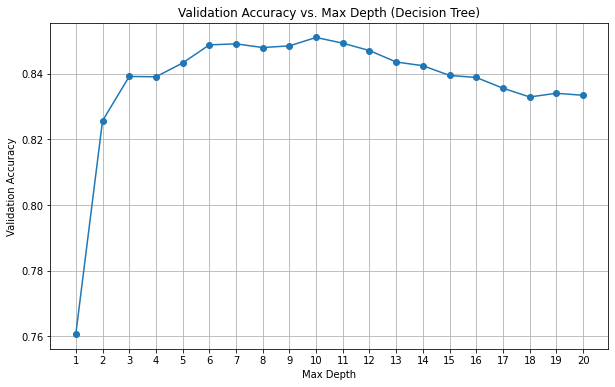


Optimal max_depth: 10

Classification Report for Decision Tree Classifier with Optimal max_depth on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7431
           1       0.76      0.55      0.64      2337

    accuracy                           0.85      9768
   macro avg       0.82      0.75      0.77      9768
weighted avg       0.84      0.85      0.84      9768

Confusion Matrix (Optimal max_depth):
[[7026  405]
 [1050 1287]]


In [24]:
# -----------------------------
# Part 6.1: Decision Tree Classifier (DecisionTreeClassifier)
# -----------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Initialize the Decision Tree Classifier
# Start with default parameters
dt_classifier = DecisionTreeClassifier(random_state=random_state)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f'\nValidation Accuracy (Decision Tree): {accuracy:.4f}')

# Evaluate the performance
print('\nClassification Report for Decision Tree Classifier on Validation Set:')
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(cm)

# -----------------------------
# Hyperparameter Tuning: Finding the Optimal Tree Depth
# -----------------------------

# Test different values of max_depth to prevent overfitting
max_depths = range(1, 21)
accuracy_scores = []

for max_depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    dt_classifier.fit(X_train, y_train)
    y_val_pred = dt_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)
    print(f'max_depth={max_depth}, Validation Accuracy: {accuracy:.4f}')

# Plot the accuracy scores vs. max_depth values
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracy_scores, marker='o')
plt.title('Validation Accuracy vs. Max Depth (Decision Tree)')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.xticks(max_depths)
plt.grid(True)
plt.show()

# Select the optimal max_depth (the one with the highest accuracy)
optimal_max_depth = max_depths[accuracy_scores.index(max(accuracy_scores))]
print(f'\nOptimal max_depth: {optimal_max_depth}')

# Retrain the Decision Tree classifier with the optimal max_depth
dt_classifier_optimal = DecisionTreeClassifier(max_depth=optimal_max_depth, random_state=random_state)
dt_classifier_optimal.fit(X_train, y_train)

# Predict on the validation set with the optimal max_depth
y_val_pred_optimal = dt_classifier_optimal.predict(X_val)

# Evaluate the performance
print('\nClassification Report for Decision Tree Classifier with Optimal max_depth on Validation Set:')
print(classification_report(y_val, y_val_pred_optimal))

# Confusion Matrix
cm_optimal = confusion_matrix(y_val, y_val_pred_optimal)
print('Confusion Matrix (Optimal max_depth):')
print(cm_optimal)



Validation Accuracy (Decision Tree with SMOTE): 0.7999

Classification Report for Decision Tree Classifier with SMOTE on Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7431
           1       0.57      0.65      0.61      2337

    accuracy                           0.80      9768
   macro avg       0.73      0.75      0.74      9768
weighted avg       0.81      0.80      0.80      9768

Confusion Matrix:
[[6289 1142]
 [ 813 1524]]
max_depth=1, Validation Accuracy: 0.7092
max_depth=2, Validation Accuracy: 0.7178
max_depth=3, Validation Accuracy: 0.7548
max_depth=4, Validation Accuracy: 0.7447
max_depth=5, Validation Accuracy: 0.7659
max_depth=6, Validation Accuracy: 0.7852
max_depth=7, Validation Accuracy: 0.7846
max_depth=8, Validation Accuracy: 0.7842
max_depth=9, Validation Accuracy: 0.7954
max_depth=10, Validation Accuracy: 0.7980
max_depth=11, Validation Accuracy: 0.8001
max_depth=12, Validation Accuracy: 0.

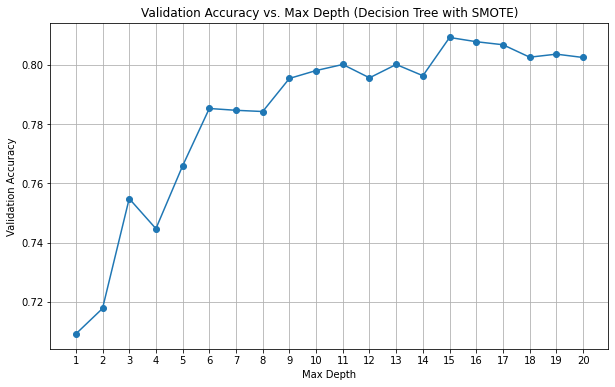


Optimal max_depth: 15

Classification Report for Decision Tree Classifier with Optimal max_depth on Validation Set:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7431
           1       0.57      0.79      0.66      2337

    accuracy                           0.81      9768
   macro avg       0.75      0.80      0.77      9768
weighted avg       0.84      0.81      0.82      9768

Confusion Matrix (Optimal max_depth):
[[6063 1368]
 [ 496 1841]]


In [19]:
# -----------------------------
# Part 6.2: Decision Tree Classifier with SMOTE
# -----------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=random_state)

# Train the classifier on the resampled training data
dt_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = dt_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f'\nValidation Accuracy (Decision Tree with SMOTE): {accuracy:.4f}')

# Evaluate the performance
print('\nClassification Report for Decision Tree Classifier with SMOTE on Validation Set:')
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(cm)

# -----------------------------
# Hyperparameter Tuning: Finding the Optimal Tree Depth with SMOTE
# -----------------------------

# Test different values of max_depth to prevent overfitting
max_depths = range(1, 21)
accuracy_scores = []

for max_depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    dt_classifier.fit(X_train_resampled, y_train_resampled)
    y_val_pred = dt_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)
    print(f'max_depth={max_depth}, Validation Accuracy: {accuracy:.4f}')

# Plot the accuracy scores vs. max_depth values
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracy_scores, marker='o')
plt.title('Validation Accuracy vs. Max Depth (Decision Tree with SMOTE)')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.xticks(max_depths)
plt.grid(True)
plt.show()

# Select the optimal max_depth (the one with the highest accuracy)
optimal_max_depth = max_depths[accuracy_scores.index(max(accuracy_scores))]
print(f'\nOptimal max_depth: {optimal_max_depth}')

# Retrain the Decision Tree classifier with the optimal max_depth
dt_classifier_optimal = DecisionTreeClassifier(max_depth=optimal_max_depth, random_state=random_state)
dt_classifier_optimal.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set with the optimal max_depth
y_val_pred_optimal = dt_classifier_optimal.predict(X_val)

# Evaluate the performance
print('\nClassification Report for Decision Tree Classifier with Optimal max_depth on Validation Set:')
print(classification_report(y_val, y_val_pred_optimal))

# Confusion Matrix
cm_optimal = confusion_matrix(y_val, y_val_pred_optimal)
print('Confusion Matrix (Optimal max_depth):')
print(cm_optimal)



Model: k-NN (k=21)
Confusion Matrix:
[[6830  601]
 [ 972 1365]]
Accuracy: 0.8390
Precision: 0.6943
Recall (Sensitivity): 0.5841
Specificity: 0.9191
F1 Score: 0.6344

Model: Naïve Bayes
Confusion Matrix:
[[3645 3786]
 [ 175 2162]]
Accuracy: 0.5945
Precision: 0.3635
Recall (Sensitivity): 0.9251
Specificity: 0.4905
F1 Score: 0.5219

Model: Decision Tree (depth=10)
Confusion Matrix:
[[7026  405]
 [1050 1287]]
Accuracy: 0.8510
Precision: 0.7606
Recall (Sensitivity): 0.5507
Specificity: 0.9455
F1 Score: 0.6389


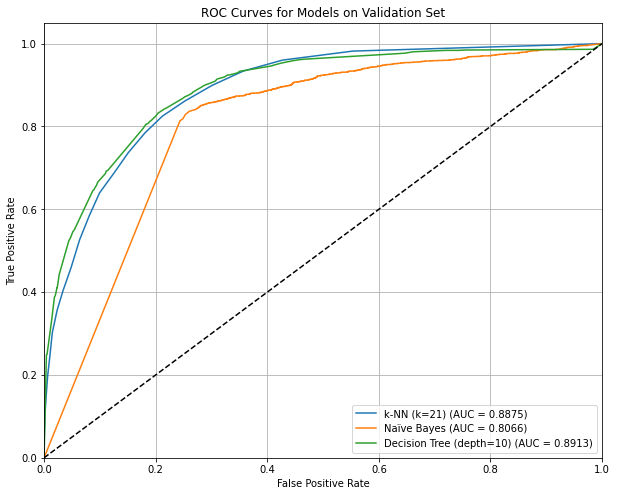

In [27]:
# -----------------------------
# Part 7: Compare the Performance of the Three Models
# -----------------------------

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Ensure that feature scaling is applied to the numerical columns
# (If not already applied, uncomment the following lines)
# numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# scaler = StandardScaler()
# X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])

# Initialize the models with the specified parameters

# 1. k-NN Classifier with k=21
knn_model = KNeighborsClassifier(n_neighbors=21)
knn_model.fit(X_train, y_train)
y_val_pred_knn = knn_model.predict(X_val)
y_val_proba_knn = knn_model.predict_proba(X_val)[:, 1]

# 2. Naïve Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_val_pred_nb = nb_model.predict(X_val)
y_val_proba_nb = nb_model.predict_proba(X_val)[:, 1]

# 3. Decision Tree Classifier with depth=10
dt_model = DecisionTreeClassifier(max_depth=10, random_state=random_state)
dt_model.fit(X_train, y_train)
y_val_pred_dt = dt_model.predict(X_val)
y_val_proba_dt = dt_model.predict_proba(X_val)[:, 1]

# Create a dictionary to store the models' names and their predictions
models = {
    'k-NN (k=21)': {'y_pred': y_val_pred_knn, 'y_proba': y_val_proba_knn},
    'Naïve Bayes': {'y_pred': y_val_pred_nb, 'y_proba': y_val_proba_nb},
    'Decision Tree (depth=10)': {'y_pred': y_val_pred_dt, 'y_proba': y_val_proba_dt}
}

# Initialize dictionaries to store metrics
metrics = {}

for model_name, model_info in models.items():
    print(f'\nModel: {model_name}')
    y_pred = model_info['y_pred']
    y_proba = model_info['y_proba']

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print('Confusion Matrix:')
    print(cm)
    
    # Calculate metrics
    TN, FP, FN, TP = cm.ravel()
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    specificity = TN / (TN + FP)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Store metrics
    metrics[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1
    }
    
    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    models[model_name]['fpr'] = fpr
    models[model_name]['tpr'] = tpr
    models[model_name]['roc_auc'] = roc_auc

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, model_info in models.items():
    plt.plot(model_info['fpr'], model_info['tpr'], label=f'{model_name} (AUC = {model_info["roc_auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models on Validation Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Confusion Matrix:
[[3523  193]
 [ 483  686]]

Test Set Performance of Decision Tree Classifier (Depth=10):
Accuracy: 0.8616
Precision: 0.7804
Recall (Sensitivity): 0.5868
Specificity: 0.9481
F1 Score: 0.6699


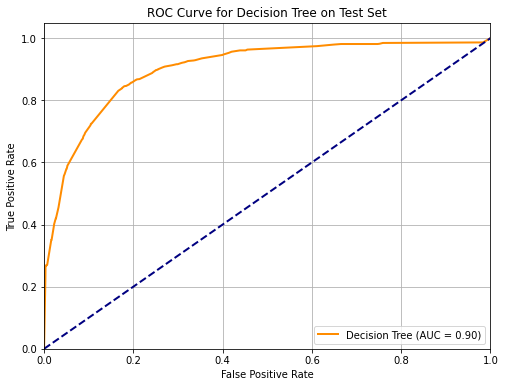

In [29]:
# -----------------------------
# Part 8: Final Test
# -----------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# The best model is the Decision Tree Classifier with max_depth=10
# Retrain the model on the training data
best_model = DecisionTreeClassifier(max_depth=10, random_state=random_state)
best_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = best_model.predict(X_test_split)
y_test_proba = best_model.predict_proba(X_test_split)[:, 1]

# Evaluate the performance
cm = confusion_matrix(y_test_split, y_test_pred)
print('Confusion Matrix:')
print(cm)

TN, FP, FN, TP = cm.ravel()
accuracy = accuracy_score(y_test_split, y_test_pred)
precision = precision_score(y_test_split, y_test_pred)
recall = recall_score(y_test_split, y_test_pred)
f1 = f1_score(y_test_split, y_test_pred)
specificity = TN / (TN + FP)

print(f'\nTest Set Performance of Decision Tree Classifier (Depth=10):')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_split, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
